# OK Google, google the NASDAQ

## Part III - Which Trends are actually behind the NASDAQ?

In the previous part, we knew that in 2020, overall, NASDAQ index is affected by COVID-19 while tending to go against special events at turning points. 

Now we go a bit further. Which aspects of our life is most concerning with the stock market? That is to say, in the eyes of the financial world, which aspects make the most money?

### Data preprocessing

Google actually divides Google Trends data into hundreds of categories and 3 levels. For this part, we collect Google Trends data in all categories and analyze the performance in different levels.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
### Data directory configs
DATA_DIR = './data/'
VIDEO_DIR = './video_data/'
PLOT_DIR = './plots_data/'

In [3]:
# Load the NASDAQ index from 2020-1-1 to 2020-12-1
df_nd = pd.read_csv(DATA_DIR + 'Composite_2020.csv')
df_nd['Date'] = pd.to_datetime(df_nd['Date'])
df_nd.set_index('Date', inplace=True)

# There is no data available in the weekends, so we pad the blank row with linear interpolation method.
df_nd = df_nd.reindex(pd.date_range(start=pd.Timestamp('2020-1-1'), end=pd.Timestamp('2020-12-1'), freq='1D'))
df_nd.iloc[0] = df_nd.iloc[1]
df_nd.interpolate(method='linear', inplace=True)    
df_nd.tail()

,Open,High,Low,Close,Adj Close,Volume
2020-11-27,12159.179688,12236.230469,12154.570313,12205.849609,12205.849609,3.401890e+09
2020-11-28,12180.869792,12239.037110,12112.100261,12203.479817,12203.479817,4.832403e+09
2020-11-29,12202.559896,12241.843750,12069.630208,12201.110026,12201.110026,6.262917e+09
2020-11-30,12224.250000,12244.650391,12027.160156,12198.740234,12198.740234,7.693430e+09
2020-12-01,12313.360352,12405.790039,12263.929688,12355.110352,12355.110352,6.467180e+09


In [4]:
# Load the Google Trends data in all categories from 2020-1-1 to 2020-12-1
df_gt = pd.read_csv(DATA_DIR + 'categories.csv')
df_gt['date'] = pd.to_datetime(df_gt['date'])
df_gt = df_gt.set_index('date')
df_gt = df_gt[pd.Timestamp('2020-1-1'):pd.Timestamp('2020-12-1')]
df_gt.tail()

,Arts & Entertainment,Autos & Vehicles,Beauty & Fitness,Books & Literature,Business & Industrial,Computers & Electronics,Finance,Food & Drink,Games,Health,...,Sightseeing Tours,Vineyards & Wine Tourism,Beaches & Islands,Historical Sites & Buildings,Lakes & Rivers,Mountain & Ski Resorts,Regional Parks & Gardens,Theme Parks,Tourist Boards & Visitor Centers,Vacation Offers
date,,,,,,,,,,,,,,,,,,,,,
2020-11-27,71.292683,70.0,79.058824,37.681159,50.022727,73.0,40.292683,47.0,75.9000,37.857143,...,37.918919,37.0,43,30.0,31.0,52.000000,48.0,24.000000,37.948718,46.109589
2020-11-28,75.804878,75.0,85.976471,45.971014,50.829545,72.0,34.146341,54.0,81.0750,39.750000,...,32.324324,40.0,47,36.0,46.0,55.151515,52.0,28.075472,39.846154,44.013699
2020-11-29,78.512195,67.0,79.058824,46.724638,47.602273,68.0,28.682927,55.0,76.7625,41.011905,...,41.027027,30.0,48,30.0,39.0,51.212121,45.0,25.358491,34.153846,41.917808
2020-11-30,74.000000,75.0,84.000000,51.246377,62.931818,83.0,51.219512,44.0,70.7250,54.261905,...,24.243243,29.0,44,30.0,42.0,52.000000,41.0,22.188679,60.717949,47.506849
2020-12-01,66.780488,69.0,77.082353,50.492754,62.931818,78.0,53.268293,43.0,68.1375,53.630952,...,26.108108,24.0,45,31.0,38.0,51.212121,39.0,20.377358,81.589744,51.698630


In [5]:
# Extract features by shifting the dataframe by 1 row.
data = df_gt.copy()
data['NASDAQ'] = df_nd['Close']
data['NASDAQ.l1'] = data['NASDAQ'].shift(1)
for col in df_gt.columns:
    data[col] = data[col].shift(1)
data = data.dropna()
data.head()

,Arts & Entertainment,Autos & Vehicles,Beauty & Fitness,Books & Literature,Business & Industrial,Computers & Electronics,Finance,Food & Drink,Games,Health,...,Beaches & Islands,Historical Sites & Buildings,Lakes & Rivers,Mountain & Ski Resorts,Regional Parks & Gardens,Theme Parks,Tourist Boards & Visitor Centers,Vacation Offers,NASDAQ,NASDAQ.l1
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,100.0,75.307692,92.0,50.0,47.0,63.228916,37.0,76.766667,85.0,45.0,...,76.0,48.164706,45.584416,93.0,56.64,55.0,59.0,74.0,9092.190430,9092.190430
2020-01-03,83.0,85.087912,98.0,52.0,60.0,81.012048,59.0,54.716667,82.0,57.0,...,77.0,46.541176,47.272727,95.0,53.76,54.0,95.0,82.0,9020.769531,9092.190430
2020-01-04,81.0,83.131868,94.0,49.0,62.0,80.024096,60.0,53.083333,73.0,57.0,...,74.0,41.129412,47.272727,100.0,55.68,49.0,90.0,77.0,9037.669596,9020.769531
2020-01-05,86.0,82.153846,98.0,47.0,49.0,69.156627,44.0,61.250000,79.0,47.0,...,76.0,41.129412,47.272727,88.0,51.84,47.0,57.0,76.0,9054.569662,9037.669596
2020-01-06,89.0,75.307692,97.0,49.0,47.0,68.168675,35.0,62.883333,82.0,46.0,...,75.0,44.376471,43.896104,84.0,52.80,48.0,48.0,74.0,9071.469727,9054.569662


### Out-of-sample forecast

In [6]:
# Still, we start from 2020-2-9
start_date = pd.Timestamp('2020-2-9')
start_index = data.index.tolist().index(start_date)

label = 'NASDAQ'
base_features = ['NASDAQ.l1']

In [7]:
# This step can be very time-consuming, so we saved the results in a csv file. Uncomment this cell and next cell to replicate the results.
# As the rolling window become broader, more data can be used for trainig. 

# base = [-1.0] * start_index
# out_base_model = LinearRegression()
# prediction = pd.DataFrame()

# for i in range(start_index, len(data)):
#     # Base model traing and predicting.
#     out_base_model.fit(data[:i][base_features], data[:i][label])
#     base_pred = out_base_model.predict([data.iloc[i][base_features]])
#     base.append(base_pred[0])
# prediction['baseline'] = base

In [8]:
# Trends model traing and predicting. 
# Features: closing prices from the previous day along with an additional Google Trends category.

# for feature in df_gt.columns:
#     trends = [-1.0] * start_index
#     trends_features = ['NASDAQ.l1', feature]
#     out_trends_model = LinearRegression()
#     for i in range(start_index, len(data)):
#         # Trends model training and predicting.
#         out_trends_model.fit(data[:i][trends_features], data[:i][label])
#         trends_pred = out_trends_model.predict([data.iloc[i][trends_features]])
#         trends.append(trends_pred[0])
#     prediction[feature] = trends
# prediction.to_csv(DATA_DIR + 'prediction.csv', index=False)

Finally, we gain all the prediction results with each category as feature.

In [9]:
df_pred = pd.read_csv(DATA_DIR + 'prediction.csv')
idx = pd.date_range('2020-1-2', '2020-12-1')
df_pred.index = idx
df_pred = df_pred[start_date:]
df_pred.head()

,baseline,Arts & Entertainment,Autos & Vehicles,Beauty & Fitness,Books & Literature,Business & Industrial,Computers & Electronics,Finance,Food & Drink,Games,...,Sightseeing Tours,Vineyards & Wine Tourism,Beaches & Islands,Historical Sites & Buildings,Lakes & Rivers,Mountain & Ski Resorts,Regional Parks & Gardens,Theme Parks,Tourist Boards & Visitor Centers,Vacation Offers
2020-02-09,9552.331617,9554.128165,9538.096715,9480.667685,9518.412401,9540.398572,9546.065457,9541.700256,9529.616506,9524.366842,...,9549.772221,9496.990142,9532.864727,9548.875862,9549.179182,9512.863776,9535.316454,9513.668037,9549.227364,9549.643567
2020-02-10,9591.901513,9595.554743,9595.126046,9566.254666,9573.223913,9579.892174,9588.023751,9572.857114,9573.725147,9580.192938,...,9593.332962,9558.015262,9590.910383,9592.398229,9589.700093,9590.566708,9579.731220,9558.945427,9591.359436,9594.169944
2020-02-11,9631.693815,9640.677292,9631.124612,9632.747320,9635.969560,9642.742352,9631.633645,9634.808543,9636.951041,9658.447307,...,9631.271345,9640.872018,9633.249740,9635.593140,9628.195633,9631.189132,9628.947118,9628.226313,9631.426509,9625.816139
2020-02-12,9642.963043,9642.185137,9642.476463,9630.916588,9645.616878,9647.337071,9642.852573,9646.231113,9645.497565,9646.756573,...,9642.315585,9649.439917,9641.345650,9649.631459,9644.138587,9642.081059,9643.572768,9637.003792,9642.348278,9640.356355
2020-02-13,9740.311425,9737.470494,9741.801795,9737.272783,9740.307924,9740.436734,9740.595855,9742.387634,9741.428985,9734.230899,...,9740.869854,9747.302437,9743.479702,9746.717838,9733.863210,9742.392245,9738.459911,9733.026208,9740.624471,9738.685464


In [10]:
# Calculate MAEs and improvements for each trends model.
df_metrics = pd.DataFrame(columns=['name', 'mae', 'improvement'])
base_mae = sum(abs(df_pred['baseline'] - data[start_date:]['NASDAQ']))/len(df_pred)

for trend in df_gt.columns:
    mae = sum(abs(df_pred[trend] - data[start_date:]['NASDAQ']))/len(df_pred)
    improvement = (base_mae - mae) / base_mae
    df_metrics = df_metrics.append({'name': trend, 'mae': mae, 'improvement': improvement}, 
                      ignore_index=True)

In [11]:
df_metrics.sort_values(by='improvement', ascending=False)

,name,mae,improvement
304,Concerts & Music Festivals,106.776815,0.056238
405,Peugeot,108.094289,0.044593
305,Film Festivals,108.263100,0.043101
246,Libraries & Museums,108.693623,0.039296
857,Formal Wear,108.827588,0.038111
...,...,...,...
15,News,117.976153,-0.042749
736,Product Liability,118.792381,-0.049964
265,Luxury Goods,120.241656,-0.062773
581,Miniatures & Wargaming,120.657874,-0.066452


From the sorted dataframe, we see that Google Trends in "Concerts & Music Festivals" improves the model by 5.6%. 

Next, analyze the relation between different levels.

In [12]:
# Load the level relation data.
relation = pd.read_csv(DATA_DIR + 'categories_relation.csv')
df_level = pd.merge(df_metrics, relation)
df_level.drop('Unnamed: 0', axis=1, inplace=True)
df_level.set_index('id', inplace=True)
df_level

,name,mae,improvement,level,parent_id
id,,,,,
3,Arts & Entertainment,113.315454,-0.001555,1,0
47,Autos & Vehicles,116.196550,-0.027020,1,0
44,Beauty & Fitness,113.333081,-0.001711,1,0
22,Books & Literature,113.808482,-0.005913,1,0
12,Business & Industrial,112.961977,0.001569,1,0
...,...,...,...,...,...
1119,Mountain & Ski Resorts,111.254111,0.016664,3,208
1007,Regional Parks & Gardens,115.871286,-0.024145,3,208
1008,Theme Parks,114.374760,-0.010918,3,208


In [13]:
level_1 = df_level[df_level['level'] == 1]
level_2 = df_level[df_level['level'] == 2]
level_3 = df_level[df_level['level'] == 3]

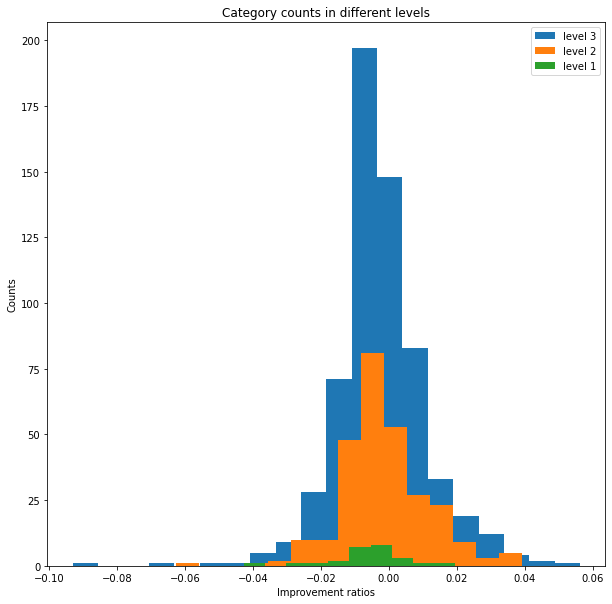

In [14]:
plt.figure(figsize=(10, 10))
plt.hist(level_3['improvement'], bins=20, histtype='stepfilled', label='level 3')
plt.hist(level_2['improvement'], bins=15, histtype='stepfilled', label='level 2')
plt.hist(level_1['improvement'], bins=10, histtype='stepfilled', label='level 1')
plt.title('Category counts in different levels')
plt.xlabel('Improvement ratios')
plt.ylabel('Counts')
plt.legend()

In [15]:
# df_level.to_csv(PLOT_DIR + 'level.csv')

In [16]:
def find_ancestor(df, id, top_level=1):
    '''
    return the ancester category in the given level.
    '''
    row = df.loc[id]
    if row['level'] == top_level:
        return row
    return find_ancestor(df, row['parent_id'])

### Feature selection method

In this section, we want to know if F-scores of categories relate to the final improvement ratios.

In [17]:
from sklearn.feature_selection import f_regression
level_1['f_scores'] = f_regression(data[level_1['name']], data['NASDAQ'])[0]
level_2['f_scores'] = f_regression(data[level_2['name']], data['NASDAQ'])[0]
level_3['f_scores'] = f_regression(data[level_3['name']], data['NASDAQ'])[0]

<ipython-input-17-9f089ecb7de7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['f_scores'] = f_regression(data[level_1['name']], data['NASDAQ'])[0]
<ipython-input-17-9f089ecb7de7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_2['f_scores'] = f_regression(data[level_2['name']], data['NASDAQ'])[0]
<ipython-input-17-9f089ecb7de7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [18]:
level_3.sort_values(by='improvement', ascending=False).head()

,name,mae,improvement,level,parent_id,f_scores
id,,,,,,
891,Concerts & Music Festivals,106.776815,0.056238,3,569,99.852699
856,Peugeot,108.094289,0.044593,3,815,109.851628
1086,Film Festivals,108.263100,0.043101,3,569,65.249068
990,Formal Wear,108.827588,0.038111,3,68,3.711307
1306,Parking,109.004497,0.036548,3,50,4.255569


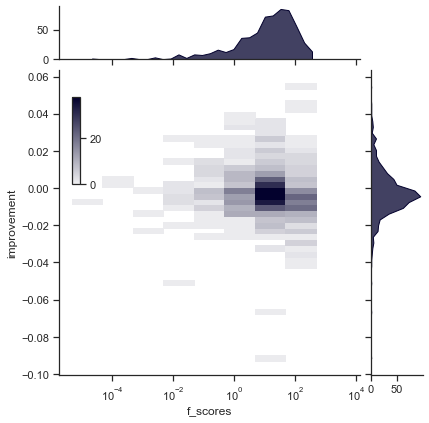

In [19]:
import seaborn as sns
sns.set_theme(style='ticks')
g = sns.JointGrid(data=level_3, x='f_scores', y='improvement', marginal_ticks=True)
g.ax_joint.set(xscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap='light:#03012d', pmax=.9, cbar=True, cbar_ax=cax 
)
g.plot_marginals(sns.histplot, element='poly', color='#03012d')

We can't tell the relation between F-scores and improvement ratios. So the feature selection can't be a weapon in our story.

### Level 1 & Level 2

For each category in level 1, we calculate:
+ A: The number of subcategories in level 2.
+ B: The number of subcategories in level 2 that improve the model (has the positive "improvement ratio")
+ Positive ratio: B/A.

In [20]:
# Nmber of subcategories in level 2.
level_2_count = level_2.groupby('parent_id').count()
level_2_pos = level_2[level_2['improvement'] >= 0]
level_2_posgroup = level_2_pos.groupby('parent_id').count()

# Number of subcategories in level 2 that improve the model
level_1['count'] = level_2_count['name']
level_1['positive count'] = level_2_posgroup['name']
level_1['positive ratio'] = level_1['positive count'] / level_1['count']

<ipython-input-20-b9739b0bad7c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['count'] = level_2_count['name']
<ipython-input-20-b9739b0bad7c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['positive count'] = level_2_posgroup['name']
<ipython-input-20-b9739b0bad7c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [21]:
# Top 5 categories that have the largest improvement ratios in level 1.
level_1.sort_values(by='improvement', ascending=False).head()

,name,mae,improvement,level,parent_id,f_scores,count,positive count,positive ratio
id,,,,,,,,,
67,Travel,110.936708,0.019470,1,0,7.822568,11,10,0.909091
533,Reference,111.891697,0.011029,1,0,46.411896,7,3,0.428571
958,Jobs & Education,112.601497,0.004755,1,0,11.619854,2,2,1.000000
71,Food & Drink,112.949250,0.001682,1,0,2.468136,7,3,0.428571
12,Business & Industrial,112.961977,0.001569,1,0,31.267150,23,7,0.304348


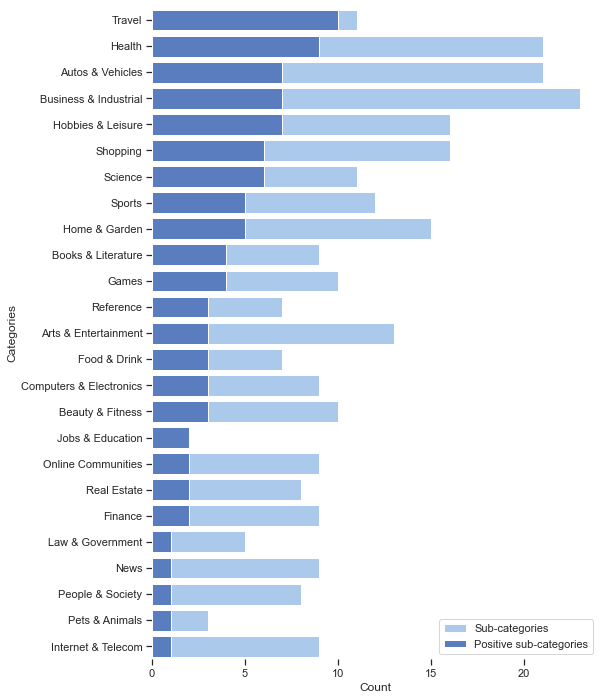

In [22]:
level_1 = level_1.sort_values(by='positive count', ascending=False)
f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes('pastel')
sns.barplot(x='count', y='name', data=level_1,
            label='Sub-categories', color='b')
sns.set_color_codes('muted')
sns.barplot(x='positive count', y='name', data=level_1,
            label='Positive sub-categories', color='b')
plt.legend()
ax.set(xlim=(0, 24), ylabel='Categories',
       xlabel='Count')
sns.despine(left=True, bottom=True)

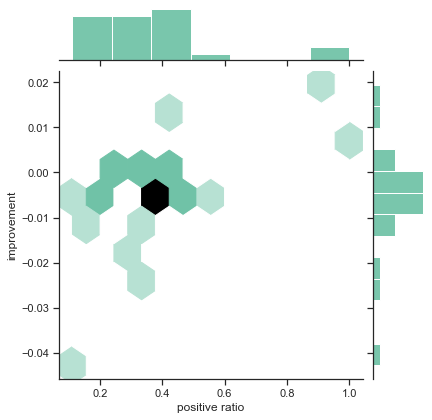

In [23]:
sns.jointplot(x=level_1['positive ratio'], y=level_1['improvement'], kind="hex", color="#4CB391")

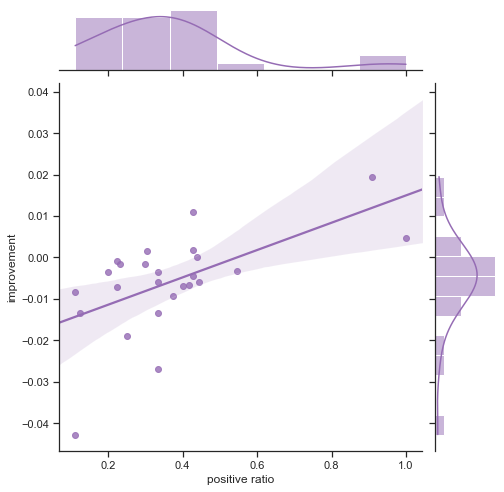

In [24]:
# Plot the relation between "positive ratio" in subcategoris and improvements.
g = sns.jointplot(x='positive ratio', y='improvement', data=level_1,
                  kind="reg", truncate=False,
                  color="m", height=7)

In [25]:
import scipy.stats as stats
stats.pearsonr(level_1['improvement'], level_1['positive ratio'])

(0.5830252068188804, 0.002222825948563236)

### Level 1 & Level 3

For each category in level 1, we calculate:
+ A: The number of subcategories in level 3.
+ B: The number of subcategories in level 3 that improve the model (has the positive "improvement ratio")
+ Positive ratio: B/A.

Note that all the categories in level 1 has subcategories in level 2. But not all categories in level 2 has children in level 3.

In [26]:
def find_top_level(df, idx):
    parent = df.loc[idx]
    return parent['parent_id']

level_3['ancenstors'] = level_3['parent_id'].apply(lambda x: find_top_level(df_level, x))

<ipython-input-26-25f07793c1c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_3['ancenstors'] = level_3['parent_id'].apply(lambda x: find_top_level(df_level, x))


In [27]:
level_3_count = level_3.groupby('ancenstors').count()
level_3_pos = level_3[level_3['improvement'] >= 0]
level_3_posgroup = level_3_pos.groupby('ancenstors').count()

level_1['level3 count'] = level_3_count['name']
level_1['level3 positive count'] = level_3_posgroup['name']
level_1['level3 positive ratio'] = level_1['level3 positive count'] / level_1['level3 count']
level_1.fillna(0, inplace=True)

In [28]:
# Top 5 categories in level 3 that improve the model most.
level_3.sort_values(by='improvement', ascending=False).head()

,name,mae,improvement,level,parent_id,f_scores,ancenstors
id,,,,,,,
891,Concerts & Music Festivals,106.776815,0.056238,3,569,99.852699,3
856,Peugeot,108.094289,0.044593,3,815,109.851628,47
1086,Film Festivals,108.263100,0.043101,3,569,65.249068,3
990,Formal Wear,108.827588,0.038111,3,68,3.711307,18
1306,Parking,109.004497,0.036548,3,50,4.255569,12


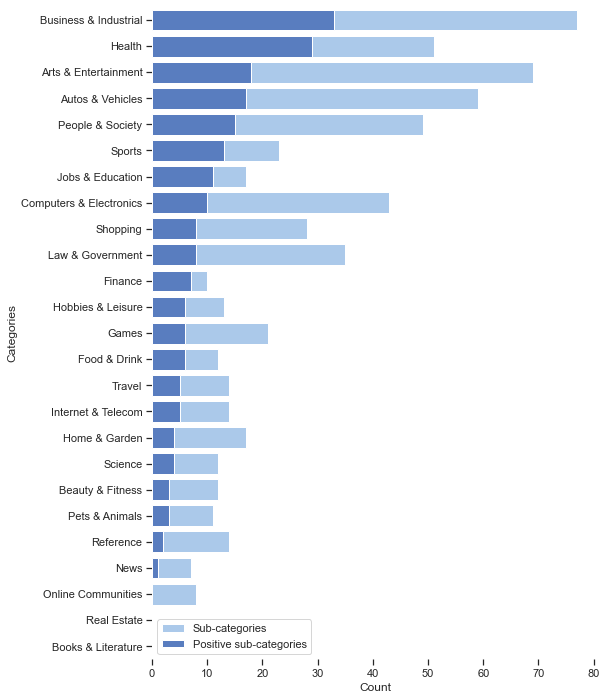

In [29]:
level_1 = level_1.sort_values(by='level3 positive count', ascending=False)
f, ax = plt.subplots(figsize=(8, 12))
sns.set_color_codes('pastel')
sns.barplot(x='level3 count', y='name', data=level_1,
            label='Sub-categories', color='b')
sns.set_color_codes('muted')
sns.barplot(x='level3 positive count', y='name', data=level_1,
            label='Positive sub-categories', color='b')
plt.legend()
ax.set(ylabel='Categories',
       xlabel='Count')
sns.despine(left=True, bottom=True)

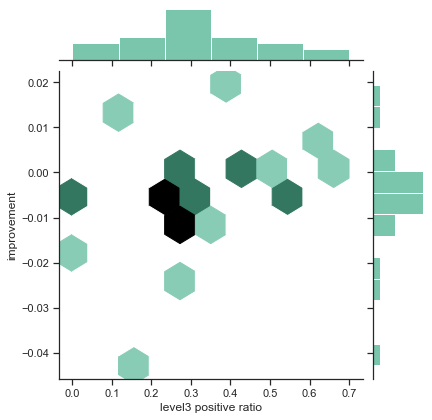

In [30]:
sns.jointplot(x=level_1['level3 positive ratio'], y=level_1['improvement'], kind="hex", color="#4CB391")

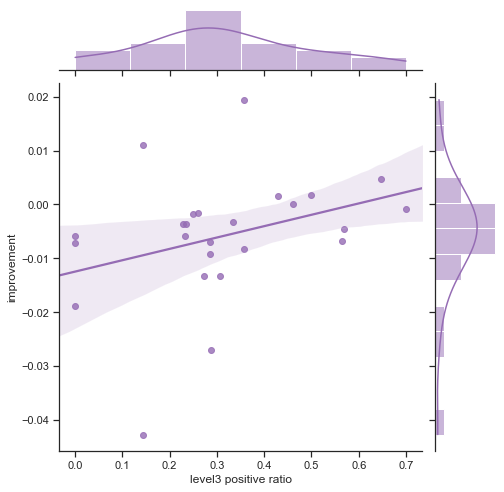

In [31]:
g = sns.jointplot(x='level3 positive ratio', y='improvement', data=level_1,
                  kind="reg", truncate=False,
                  color="m", height=7)

In [32]:
stats.pearsonr(level_1['improvement'], level_1['level3 positive ratio'])

(0.33415949402963574, 0.10255707809825189)

For level 1 and level 3, we can't say that there is relation between positive ratios and improvement ratios.

### Level 2 & Level 3

For each category in level 2, we calculate:
+ A: The total number of subcategories in level 3.
+ B: The number of subcategories in level 3 that improve the model (has the positive "improvement ratio")
+ Positive ratio: B/A.

Note that not all categories in level 2 has children in level 3. We only focus on categories that have children.

In [33]:
level_3_count = level_3.groupby('parent_id').count()
level_3_pos = level_3[level_3['improvement'] >= 0]
level_3_posgroup = level_3_pos.groupby('parent_id').count()

level_2['count'] = level_3_count['name']
level_2['positive count'] = level_3_posgroup['name']
level_2['positive ratio'] = level_2['positive count'] / level_2['count']

<ipython-input-33-de9e23f50f2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_2['count'] = level_3_count['name']
<ipython-input-33-de9e23f50f2d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_2['positive count'] = level_3_posgroup['name']
<ipython-input-33-de9e23f50f2d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [34]:
level_2_clean = level_2.dropna()

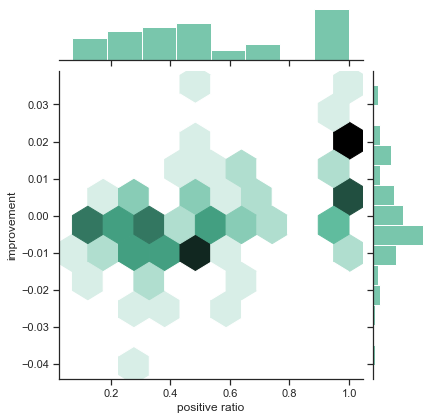

In [35]:
sns.jointplot(x=level_2_clean['positive ratio'], y=level_2_clean['improvement'], kind="hex", color="#4CB391")

<Figure size 864x864 with 0 Axes>

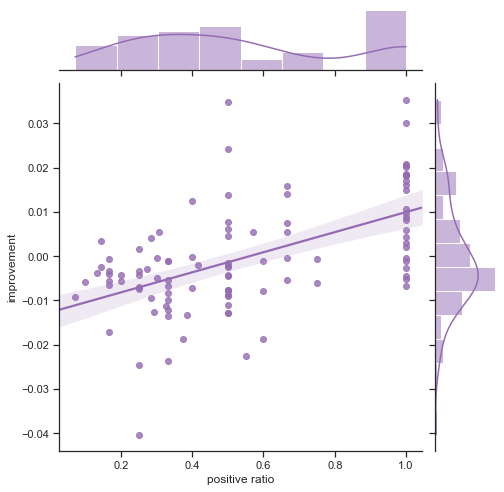

In [36]:
plt.figure(figsize=(12, 12))
g = sns.jointplot(x='positive ratio', y='improvement', data=level_2_clean,
                  kind="reg", truncate=False,
                  color="m", height=7)
# plt.savefig(VIDEO_DIR + 'relation23.png', bbox_inches = 'tight', transparent = True)

In [37]:
stats.pearsonr(level_2_clean['improvement'], level_2_clean['positive ratio'])

(0.5485797823846447, 2.8693113269038653e-09)

In [38]:
# level_2_clean.to_csv(PLOT_DIR + 'level_2.csv')

For level 2 and level 3, the "improvement ratios" are positively correlated with "positive ratios" 

### Overview

In [39]:
# For best categories in level 3, find their ancenstors in level 1 
df_top = level_3.sort_values(by='improvement', ascending=False).head(20)
for i, row in df_top.iterrows():
    print(find_ancestor(df_level, row['parent_id'])['name'])

Arts & Entertainment
Autos & Vehicles
Arts & Entertainment
Shopping
Business & Industrial
Business & Industrial
Health
Business & Industrial
Travel
Business & Industrial
Health
Health
Travel
Sports
Jobs & Education
Autos & Vehicles
Business & Industrial
Health
Shopping
Health


In [40]:
# Again, the best categories in all levels.
df_level.sort_values(by='improvement', ascending=False).head(30)

,name,mae,improvement,level,parent_id
id,,,,,
891,Concerts & Music Festivals,106.776815,0.056238,3,569
856,Peugeot,108.094289,0.044593,3,815
1086,Film Festivals,108.263100,0.043101,3,569
375,Libraries & Museums,108.693623,0.039296,2,533
990,Formal Wear,108.827588,0.038111,3,68
1306,Parking,109.004497,0.036548,3,50
206,Cruises & Charters,109.030761,0.036316,2,67
623,Aging & Geriatrics,109.140822,0.035343,2,45
1010,Travel Agencies & Services,109.188057,0.034925,2,67


Leisure and Healthcare are both good indicators of Stock in this unprecedented year.